In [23]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt
from glob import glob

In [24]:
# change working directory
# os.chdir("/content/drive/MyDrive/dl-project/Flickr_Data")
#print current working directory
print(f'Current working directory:\n\n{os.getcwd()}')
# Load data
# images_dir = os.listdir("/content/drive/MyDrive/dl-project/Flickr_Data/")
# create paths
images_path = '../flickr8k/Images/'
captions_path = '../flickr8k/Flickr_TextData/Flickr8k.token.txt'
train_path = '../flickr8k/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = '../flickr8k/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = '../flickr8k/Flickr_TextData/Flickr_8k.testImages.txt'

Current working directory:

/content/drive/MyDrive/dl-project/model


In [25]:
# load data
captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [26]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

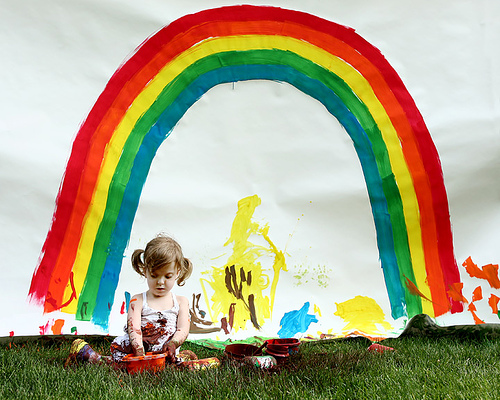

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [27]:
# displaying an image and captions given to it
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [40]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('dataset/flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('dataset/flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('dataset/flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [41]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [34]:
# Loading 50 layer Residual Network Model and getting the summary of the model
from IPython.core.display import display, HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
# model.summary()
# Note: For more details on ResNet50 architecture you can click on hyperlink given below

In [35]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [36]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

1000
2000
3000


In [37]:
train_data['2513260012_03d33305cf.jpg'].shape

(2048,)

In [42]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("./dataset/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [43]:
pd_dataset.head()

image_id  \
0  2513260012_03d33305cf.jpg   
1  2513260012_03d33305cf.jpg   
2  2513260012_03d33305cf.jpg   
3  2513260012_03d33305cf.jpg   
4  2513260012_03d33305cf.jpg   

                                            captions  
0  <start> A black dog is running after a white d...  
1  <start> Black dog chasing brown dog through sn...  
2  <start> Two dogs chase each other across the s...  
3  <start> Two dogs play together in the snow . <...  
4  <start> Two dogs running through a low lying b...

In [44]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

30000


In [45]:
# First 5 captions stored in sentences
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [46]:
# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]

In [47]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [48]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [49]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253


In [50]:
indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

In [51]:
# Download Dictionary
with open('../vocab/w2i.pickle', 'wb') as handle:
  pickle.dump(word_2_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../vocab/i2w.pickle', 'wb') as handle:
  pickle.dump(indices_2_word, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[8051])

3997
bear
2140
catch


In [53]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [54]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [55]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


(30000,)
(30000,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [57]:
# print(padded_sequences[0])

In [58]:
# for ix in range(len(padded_sequences[0])):
#     for iy in range(max_len):
#         print(indices_2_word[padded_sequences[0][ix][iy]],)
#     print("\n")

# print(len(padded_sequences[0]))

In [59]:
num_of_images = 2000

In [60]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [61]:
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

# np.save("captions.npy", captions)
# np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [63]:
imgs = []
# for each img,caption pair 
for ix in range(ds.shape[0]):
    test = str(ds[ix,0].encode()).split("'")[1]
    #ds[ix, 0].encode()
    if test in train_data.keys():
         #print(ix, encoded_images[ds[ix, 0].encode()])
         imgs.append(list(train_data[test]))

imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [64]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

# np.save("images.npy", images)

print(images.shape)

(25493, 2048)


In [65]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

# np.save("image_names.npy", image_names)

print(len(image_names))

25493


# Model



## Create the model

In [66]:
embedding_size = 128
max_len = 40

In [67]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 40, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [69]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1056512   
                                                                 
 lstm (LSTM)                 (None, 40, 256)           394240    
                                                                 
 time_distributed (TimeDistr  (None, 40, 128)          32896     
 ibuted)                                                         
                                                                 
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [70]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 dense_input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      1056512     ['embedding_input[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 128)          262272      ['dense_input[0][0]']            
                                                                                              

## Test the model

In [71]:
# Define early stopping and 
# checkpoint = ModelCheckpoint(os.getcwd()+'/best_model_km.hdf5', save_best_only=True)
early_stop = EarlyStopping(monitor ="loss",patience=5, restore_best_weights=True)
hist = model.fit([images, captions], next_words,
                 batch_size=512,
                 epochs=200,
                 callbacks=[early_stop])

Epoch 1/200
50/50 [==============================] - 12s 104ms/step - loss: 5.6573 - accuracy: 0.0850
Epoch 2/200
50/50 [==============================] - 5s 103ms/step - loss: 5.2001 - accuracy: 0.1076
Epoch 3/200
50/50 [==============================] - 5s 103ms/step - loss: 5.2810 - accuracy: 0.0786
Epoch 4/200
50/50 [==============================] - 5s 104ms/step - loss: 5.1254 - accuracy: 0.1000
Epoch 5/200
50/50 [==============================] - 5s 102ms/step - loss: 4.9427 - accuracy: 0.1182
Epoch 6/200
50/50 [==============================] - 5s 101ms/step - loss: 5.0194 - accuracy: 0.0989
Epoch 7/200
50/50 [==============================] - 5s 103ms/step - loss: 4.9205 - accuracy: 0.1089
Epoch 8/200
50/50 [==============================] - 5s 102ms/step - loss: 4.8037 - accuracy: 0.1248
Epoch 9/200
50/50 [==============================] - 5s 102ms/step - loss: 4.6908 - accuracy: 0.1315
Epoch 10/200
50/50 [==============================] - 5s 104ms/step - loss: 4.5565 - accur

## Predictions

In [72]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [73]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [74]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [75]:
def predict_captions(image,model):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])



In [80]:
# load the paths of all images to a list
images_list = glob('../flickr8k/Images/*.jpg')
len(images_list)
#define variables and make a prediction
start_idx = 800
imgs = 3 

In [81]:
def predictor(start_idx = 0, imgs_to_pred = 5, images_list=images_list, model=model):
  for idx in range(start_idx,start_idx+imgs_to_pred):
    img = images_list[idx]
    test_img = get_encoding(resnet, img)
    Argmax_Search = predict_captions(test_img,model)
    z = Image(filename=img)
    display(z)
    print(f"{Argmax_Search}\n")

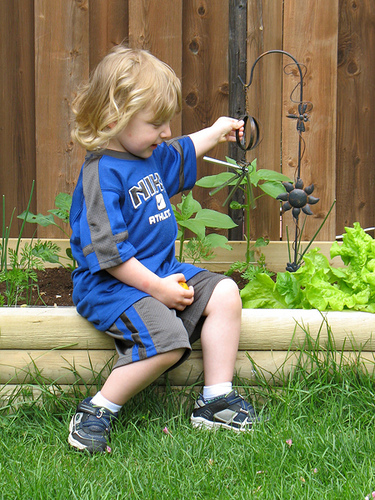

A little girl in a pink hat is standing through the camera while is is water Group with a marker .



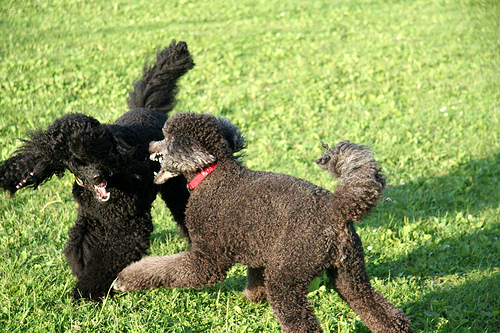

A tan dog running through a field and area with grass .



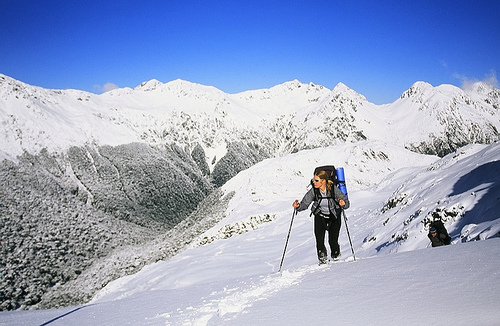

A man wearing a white is is top on a air of a snowy mountains .



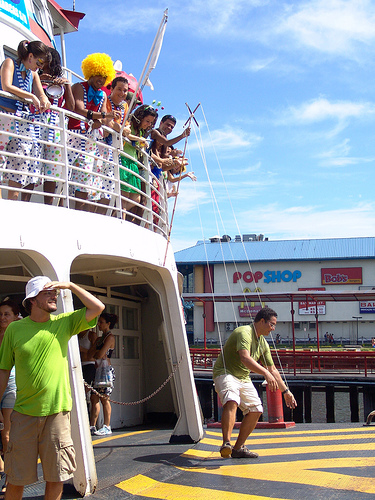

A man wearing sunglasses stands by a large skating at a cafe .



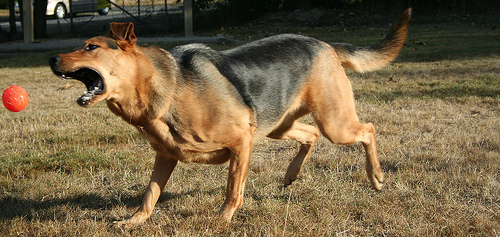

A brown dogs are playing at the Frisbee .



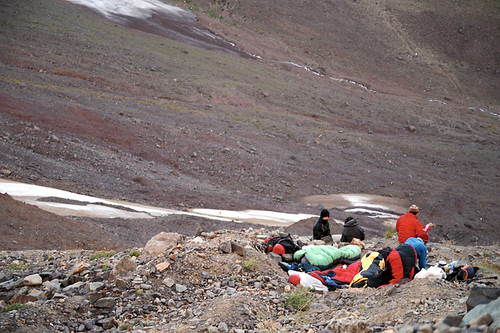

A group camps in a desolate area .



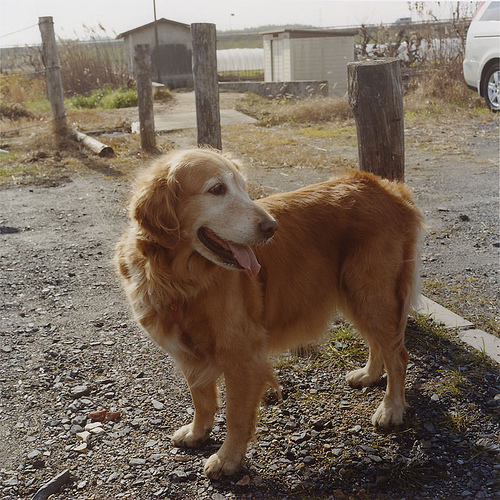

A brown dog is running through the grass with a bird in its mouth .



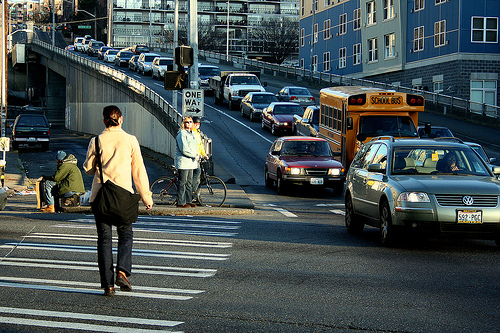

A couple walking past a huge huge painted boots boots .



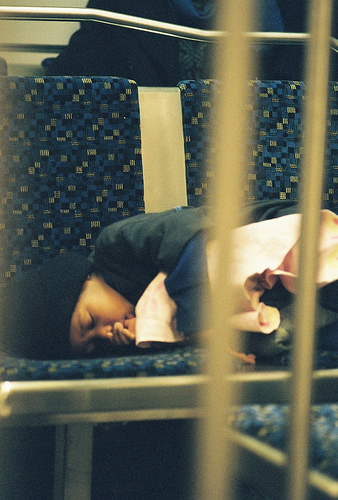

A boy jumps into the top while from a blue blue blue blue blue blue blue is pairs pairs white white white white white air pairs white white white air pairs white air friends vendor vendor vendor asian asian



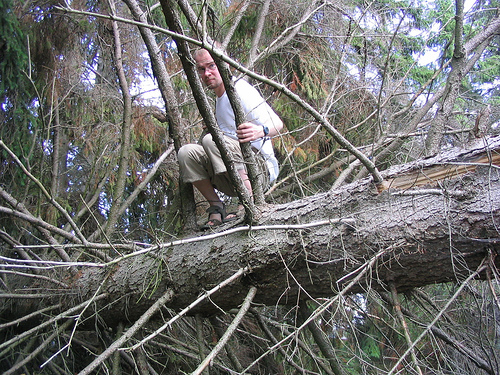

A person in a white helmet is at the air at the air at the pink light



In [84]:
for idx in range(0,10):
  img = images_list[idx]
  test_img = get_encoding(resnet, img)
  Argmax_Search = predict_captions(test_img,model)
  z = Image(filename=img)
  display(z)
  print(f"{Argmax_Search}\n")

## Save the model

In [85]:
model_json = model.to_json()
with open("./checkpoint/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./checkpoint/model.h5")
print("Saved model to disk")

Saved model to disk


## Load the model

In [86]:
json_file = open('./checkpoint/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./checkpoint/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [87]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

## Test the loaded model

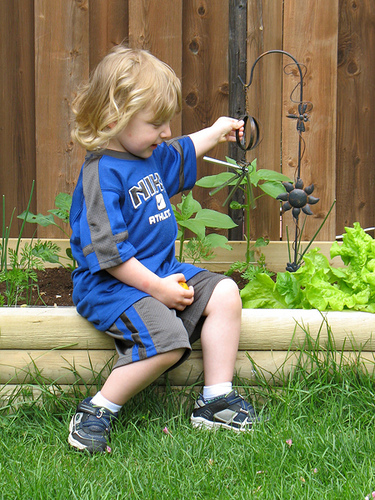

A little girl in a pink hat is standing through the camera while is is water Group with a marker .



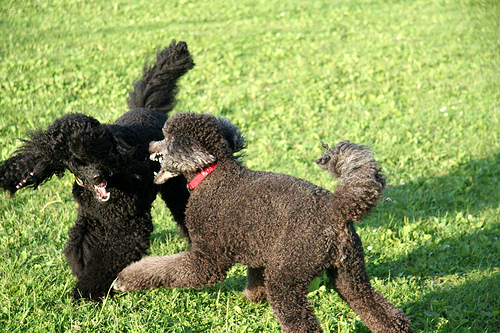

A tan dog running through a field and area with grass .



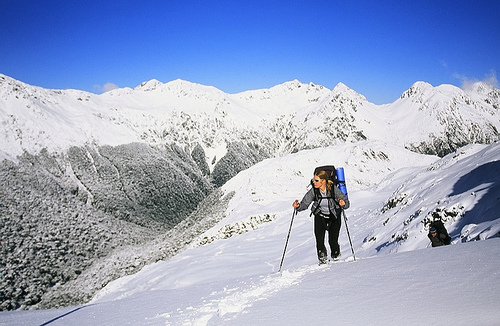

A man wearing a white is is top on a air of a snowy mountains .



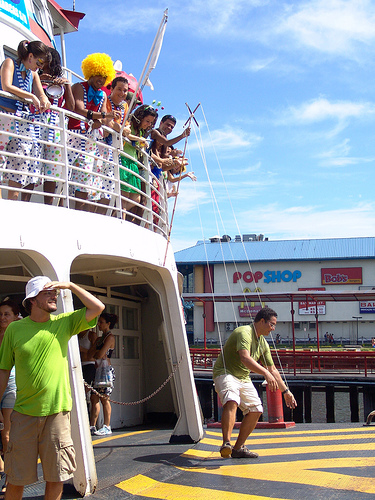

A man wearing sunglasses stands by a large skating at a cafe .



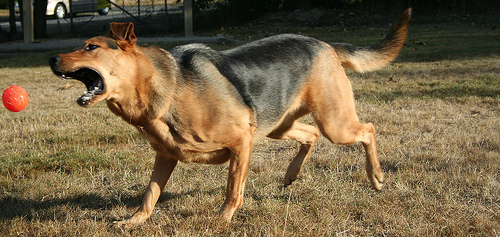

A brown dogs are playing at the Frisbee .



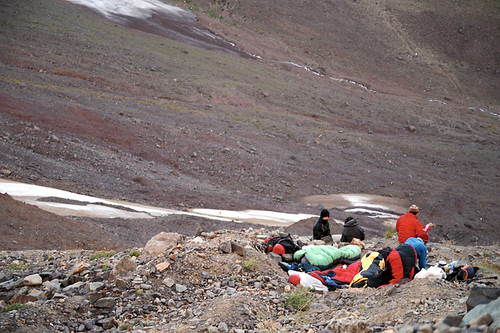

A group camps in a desolate area .



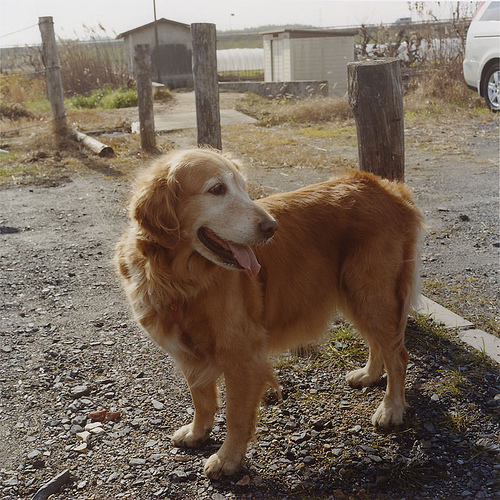

A brown dog is running through the grass with a bird in its mouth .



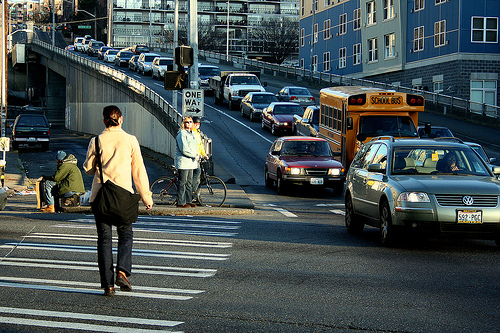

A couple walking past a huge huge painted boots boots .



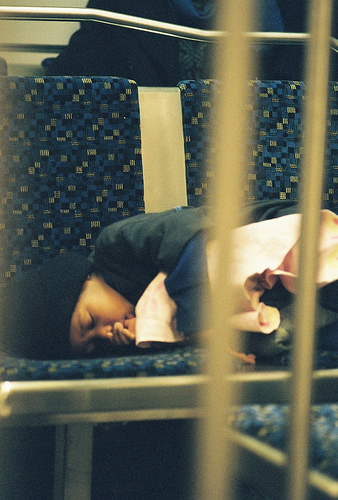

A boy jumps into the top while from a blue blue blue blue blue blue blue is pairs pairs white white white white white air pairs white white white air pairs white air friends vendor vendor vendor asian asian



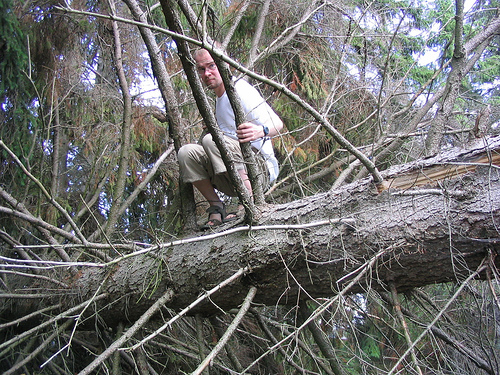

A person in a white helmet is at the air at the air at the pink light



In [89]:
for idx in range(0,10):
  img = images_list[idx]
  test_img = get_encoding(resnet, img)
  Argmax_Search = predict_captions(test_img,loaded_model)
  z = Image(filename=img)
  display(z)
  print(f"{Argmax_Search}\n")